<a target="_blank" href="https://colab.research.google.com/github/cboettig/rl-minicourse/blob/main/challenge.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

#  Conservation Gym Testbed

In this example, we set up a generic three species, two action problem, and illustrate how to provide a custom population dynamics function, action function, and utility function to represent a caribou conservation objective.  

In [1]:
# we'll need these packages to begin
# !pip install stable-baselines3 plotnine polars sb3_contrib tensorboard


In [2]:
#import os
#os.environ["CUDA_VISIBLE_DEVICES"] = "0" # change to -1 if you want to use CPU

import torch
torch.cuda.get_device_properties(0)

_CudaDeviceProperties(name='Quadro RTX 8000', major=7, minor=5, total_memory=48405MB, multi_processor_count=72, uuid=548d9b1b-2cf2-6e95-b896-a178cb839ab6, L2_cache_size=6MB)

## Caribou - Moose - Wolves System


$$X_{t+1} = X_t + r_x X \left( 1 -  \frac{X +\tau_{xy} Y}{K} \right) - \frac{ \beta Z X^2}{v_0^2 + h_x X^2 + h_y Y^2} + \sigma_x X \xi_x$$

$$Y_{t+1} = Y_t + r_y Y \left( 1 - \frac{Y +\tau_{yx} X}{K} \right) - \frac{ \beta Z X^2}{v_0^2 + h_x X^2 + h_y Y^2} + \sigma_y Y \xi_y$$

$$Z_{t+1} = Z_t + \alpha \beta Z \frac{X^2 + Y^2}{v_0^2 +  h_x X^2 + h_y Y^2} - d_H Z + \sigma_z Z \xi_z$$

In [3]:
import numpy as np
def dynamics(pop, effort, harvest_fn, p, timestep=1):

    pop = harvest_fn(pop, effort)        
    X, Y, Z = pop[0], pop[1], pop[2]
    
    ## env fluctuations
    K = p["K"] # - 0.2 * np.sin(2 * np.pi * timestep / 3200)
    beta = p["beta"]#  + 0.2 * np.sin(2 * np.pi * timestep / 3200)

    X += (p["r_x"] * X * (1 - (X + p["tau_xy"] * Y) / K)
            -  beta * Z * (X**2) / (p["v0"]**2 + p["h_x"] * X**2 + p["h_y"] * Y**2)
            + p["sigma_x"] * X * np.random.normal()
            )
    
    Y += (p["r_y"] * Y * (1 - (Y + p["tau_yx"]* X ) / K )
            - beta * Z * (Y**2) / (p["v0"]**2 + + p["h_x"] * X**2 + p["h_y"] * Y**2)
            + p["sigma_y"] * Y * np.random.normal()
            )

    Z += p["alpha"] * beta * Z * (
            (Y**2 + X**2) / (p["v0"]**2 ++ p["h_x"] * X**2 + p["h_y"] * Y**2)
            ) - p["dH"] * Z +  p["sigma_z"] * Z  * np.random.normal()
    
    pop = np.array([X, Y, Z], dtype=np.float32)
    pop = np.clip(pop, [0,0,0], [np.Inf, np.Inf, np.Inf])
    return(pop)


In [4]:

initial_pop = [0.2, 0.5, 0.05]


parameters = {
"r_x": np.float32(0.13),
"r_y": np.float32(0.2),
"K": np.float32(1),
"beta": np.float32(.4),
"v0":  np.float32(0.1),
"h_x": np.float32(0.2),
"h_y": np.float32(0.8),
"tau_yx": np.float32(0.3),
"tau_xy": np.float32(0.9),
"alpha": np.float32(.03), 
"dH": np.float32(0.015),
"sigma_x": np.float32(0.05),
"sigma_y": np.float32(0.05),
"sigma_z": np.float32(0.05)
}


We must also define the dynamics of the action, a 'harvest' or culling function.  In this scenario, we imagine that we can cull either the elk or wolf population (or both).  We assume our control action introduces a percent mortality equal to the control effort applied times a catachability coefficient:

In [5]:
def harvest(pop, effort):
    q1 = .2
    q2 = .2
    #pop[0] = pop[0] * (1 - effort[0] * q0) # pop 0, Caribou
    pop[1] = pop[1] * (1 - effort[0] * q1) # pop 0, Moose cull
    pop[2] = pop[2] * (1 - effort[1] * q2) # pop 2, Wolf cull
    return pop


Lastly, we need to define the utility or reward derived from taking these actions under this population state.  In this scenario, our population control actions are costly, while we acrue a benefit proportional to the size of the current caribou population:

In [6]:
def utility(pop, effort):
    # Caribou has direct value
    benefits = 1 * pop[0] 
    
    # small cost to any harvesting
    costs = .00001 * sum(effort) # cost to culling

    # extinction penalty
    if np.any(pop <= 0.0001):
        benefits -= 10
    return benefits - costs




To simulate our environment and allow RL algorithms to train on this environment, we define a simple python class using the gym module.  This class defines the possible action space as two continuously-valued action variables (culling effort of elk and wolves respectively), and three continuously valued state variables (population of elk, caribou and wolves).  To improve performance of RL training, it is necessary to transform the continuous space to -1, 1

In [7]:
import gymnasium as gym

class caribou(gym.Env):
    """A 3-species ecosystem model with two control actions"""
    def __init__(self, config=None):
        config = config or {}
                                
        ## these parameters may be specified in config                                  
        self.Tmax = config.get("Tmax", 800)
        self.threshold = config.get("threshold", np.float32(1e-4))
        self.init_sigma = config.get("init_sigma", np.float32(1e-3))
        self.training = config.get("training", True)
        self.initial_pop = config.get("initial_pop", initial_pop)
        self.parameters = config.get("parameters", parameters)
        self.dynamics = config.get("dynamics", dynamics)
        self.harvest = config.get("harvest", harvest)
        self.utility = config.get("utility", utility)
        self.observe = config.get("observe", lambda state: state) # default to perfectly observed case
        self.bound = 2 * self.parameters["K"]
        
        self.action_space = gym.spaces.Box(
            np.array([-1, -1], dtype=np.float32),
            np.array([1, 1], dtype=np.float32),
            dtype = np.float32
        )
        self.observation_space = gym.spaces.Box(
            np.array([-1, -1, -1], dtype=np.float32),
            np.array([1, 1, 1], dtype=np.float32),
            dtype=np.float32,
        )        
        self.reset(seed=config.get("seed", None))


    def reset(self, *, seed=None, options=None):
        self.timestep = 0
        self.initial_pop += np.multiply(self.initial_pop, np.float32(self.init_sigma * np.random.normal(size=3)))
        self.state = self.state_units(self.initial_pop)
        info = {}
        return self.observe(self.state), info


    def step(self, action):
        action = np.clip(action, self.action_space.low, self.action_space.high)
        pop = self.population_units(self.state) # current state in natural units
        effort = (action + 1.) / 2

        # harvest and recruitment
        reward = self.utility(pop, effort)
        nextpop = self.dynamics(pop, effort, self.harvest, self.parameters, self.timestep)
        
        self.timestep += 1
        terminated = bool(self.timestep > self.Tmax)
        
        # in training mode only: punish for population collapse
        if any(pop <= self.threshold) and self.training:
            terminated = True
            reward -= 50/self.timestep
        
        self.state = self.state_units(nextpop) # transform into [-1, 1] space
        observation = self.observe(self.state) # same as self.state
        return observation, reward, terminated, False, {}
    
    def state_units(self, pop):
        self.state = 2 * pop / self.bound - 1
        self.state = np.clip(self.state,  
                             np.repeat(-1, self.state.__len__()), 
                             np.repeat(1, self.state.__len__()))
        return np.float32(self.state)
    
    def population_units(self, state):
        pop = (state + 1) * self.bound /2
        return np.clip(pop, 
                       np.repeat(0, pop.__len__()),
                       np.repeat(np.Inf, pop.__len__()))
    
# verify that the environment is defined correctly    
from stable_baselines3.common.env_checker import check_env
env = caribou()
check_env(env, warn=True)    


In [8]:

env = caribou({'parameters': parameters, 'harvest': harvest, 'dynamics': dynamics, 'utility': utility, 'initial_pop': initial_pop})


# Simulate management

In [9]:

# A simple agent
class fixed_action:
    def __init__(self, effort):
        self.action = np.array(effort, dtype=np.float32)

    def predict(self, observation, **kwargs):
        return self.action, {}

# This Agent always gives the same action:
do_nothing = fixed_action([-1,-1])
do_nothing.predict([1,1,1])

(array([-1., -1.], dtype=float32), {})

In [10]:
def simulate(agent, env, timeseries = True):
    df = []
    episode_reward = 0
    observation, _ = env.reset()
    for t in range(env.Tmax):
      obs = env.population_units(observation) # natural units
      action, _ = agent.predict(obs, deterministic=True)
      if timeseries:
          df.append([t, episode_reward, *action, *obs])
      observation, reward, terminated, done, info = env.step(action)
      episode_reward += reward
      if terminated or done:
        break
    
    return df, episode_reward


In [11]:
import polars as pl
from plotnine import ggplot, aes, geom_line
cols = ["t", "reward", "moose_cull", "wolf_cull", "X", "Y", "Z"]

def plot_sim(df):
    dfl = (pl.DataFrame(df, schema=cols).
            select(["t", "X", "Y", "Z"]).
            melt("t")
          )
    gg = ggplot(dfl, aes("t", "value", color="variable")) + geom_line()
    return gg

def plot_policy(df):
    dfl = (pl.DataFrame(df, schema=cols, orient="row").
            select(["t", "reward", "moose_cull", "wolf_cull"]).
            unpivot(index = "t")
          )
    gg = ggplot(dfl, aes("t", "value", color="variable")) + geom_line()
    return gg

138.51878994703293


/tmp/ipykernel_26882/3003166500.py:6: DataOrientationWarning: Row orientation inferred during DataFrame construction. Explicitly specify the orientation by passing `orient="row"` to silence this warning.
/tmp/ipykernel_26882/3003166500.py:8: DeprecationWarning: `DataFrame.melt` is deprecated. Use `unpivot` instead, with `index` instead of `id_vars` and `on` instead of `value_vars`


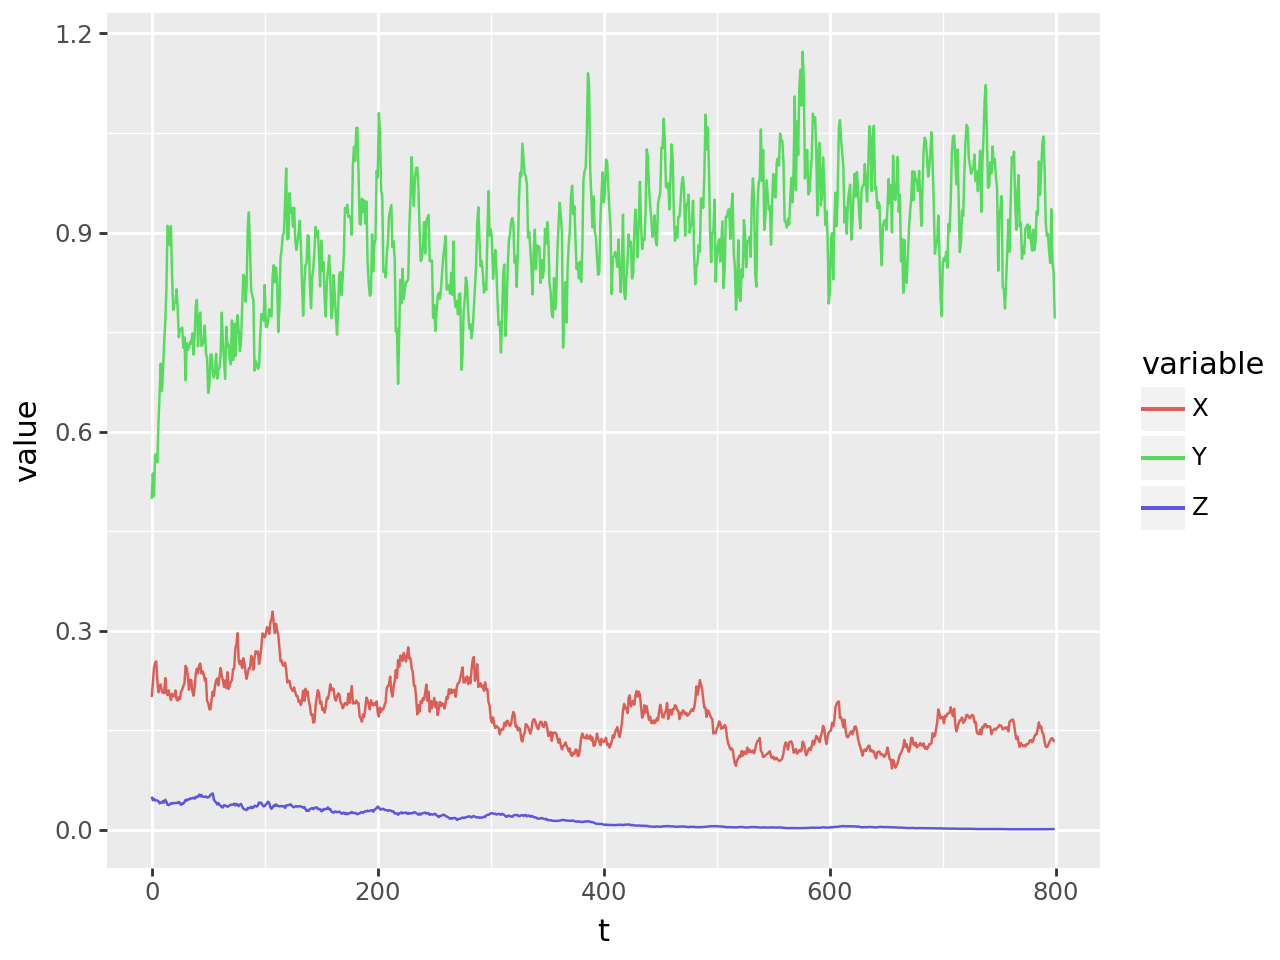

In [12]:
agent = fixed_action([-1, -1]) # No action!
#agent = fixed_action([.45, -.8]) # Optimal?
#agent = fixed_action([1, 1]) # max culls!

df, episode_reward = simulate(agent, env)
print(episode_reward)

plot_sim(df)

# Fixed strategy optimization

In [13]:
from skopt import gp_minimize, gbrt_minimize
from skopt.plots import plot_objective, plot_convergence, plot_gaussian_process

def g(x):
    agent = fixed_action(x)
    def my_function(i):
        np.random.seed(i)
        df, mu = simulate(agent, env, timeseries=False)
        return mu
        
    results = [my_function(i) for i in range(100)]
    return -np.mean(results)


In [14]:
%%time

# look for actions between [-1,1] for each species.
res = gp_minimize(g, [(-1.0, 1.0), (-1.0, 1.0)], n_calls = 50, verbose=True, n_jobs=-1)
res.fun, res.x

Iteration No: 1 started. Evaluating function at random point.
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 3.1040
Function value obtained: -37.1057
Current minimum: -37.1057
Iteration No: 2 started. Evaluating function at random point.
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 3.0055
Function value obtained: -35.3666
Current minimum: -37.1057
Iteration No: 3 started. Evaluating function at random point.
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 40.3883
Function value obtained: -388.8163
Current minimum: -388.8163
Iteration No: 4 started. Evaluating function at random point.
Iteration No: 4 ended. Evaluation done at random point.
Time taken: 4.0053
Function value obtained: -40.4241
Current minimum: -388.8163
Iteration No: 5 started. Evaluating function at random point.
Iteration No: 5 ended. Evaluation done at random point.
Time taken: 5.3036
Function value obtained: -73.6995
Current minimum: -388.8163
Iteration 

(-526.4930633708208, [-0.04858932430491414, -0.7462402721276451])

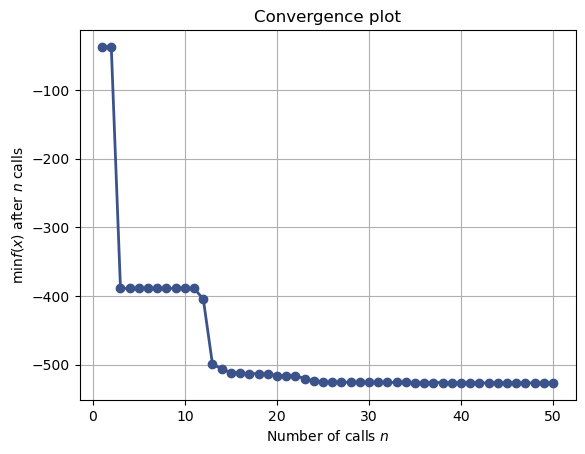

In [15]:
import matplotlib.pyplot as plt

ax2 = plot_convergence(res)

plt.show()

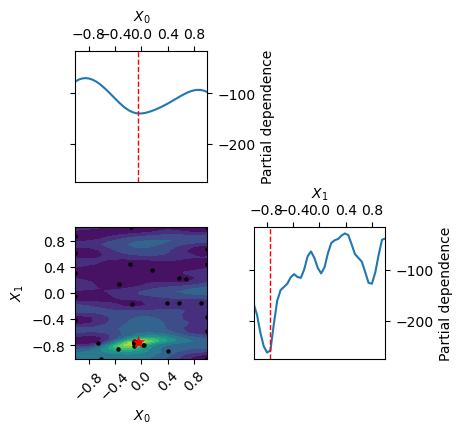

In [16]:

ax = plot_objective(res)

plt.show()

## RL Agents

In [17]:
from sb3_contrib import TQC, ARS
from stable_baselines3 import PPO, A2C, DQN, SAC, TD3
from stable_baselines3.common.env_util import make_vec_env
vec_env = make_vec_env(caribou, 12)


In [ ]:
model = ARS("MlpPolicy", vec_env, verbose=0, tensorboard_log="/home/jovyan/logs")
model.learn(total_timesteps=2_000_000, tb_log_name= "ars_caribou_1")
model.save("ars_caribou_1")


In [ ]:
model = ARS("MlpPolicy", env)
agent = model.load("ars_caribou_1")


df, episode_reward = simulate(agent, env)
print(episode_reward)

#plot_sim(df)
cols = ["t", "reward", "moose_cull", "wolf_cull", "X", "Y", "Z"]

dfl = (pl.DataFrame(df, schema=cols).
        select(["t", "moose_cull", "wolf_cull", "X", "Y", "Z"]).
        melt("t")
      )
ggplot(dfl, aes("t", "value", color="variable")) + geom_line()

In [ ]:

model = PPO("MlpPolicy", vec_env, verbose=0, tensorboard_log="/home/jovyan/logs", use_sde=True, device='cpu')
model.learn(total_timesteps=2_000_000,  tb_log_name= "ppo_caribou_1")
model.save("ppo_caribou_1")

In [ ]:


model = PPO("MlpPolicy", env)
agent = model.load("ppo_caribou_1")

df, episode_reward = simulate(agent, env)
print(episode_reward)

plot_sim(df)


In [ ]:
model = TQC("MlpPolicy", env, verbose=0, tensorboard_log="/home/jovyan/logs", use_sde=True, device = "cuda")
model.learn(total_timesteps=1_000_000 tb_log_name= "tqc_caribou_1")
model.save("tqc_caribou_1")

In [ ]:

model = TQC("MlpPolicy", env)
agent = model.load("tqc_caribou_1")


df, episode_reward = simulate(agent, env)
print(episode_reward)

plot_sim(df)
